In [11]:
import torch
import torchvision
import torch.utils.data as Data
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import numpy as np
import random 
 
%matplotlib inline
import time

In [13]:
#from google.colab import drive
#drive.mount('/content/drive/')  # 将google硬盘挂载在/comtent/drive/目录上面

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
#数据文件夹
#data_path='/content/drive/My Drive/data'
data_path='./mnist'
#模型文件夹
#model_path='/content/drive/My Drive/saved_ave_model.pt'
model_path='./saved_ave_model.pt'

In [22]:
# 超参数
#批次大小
BATCH_SIZE = 64
#学习率
LEARNING_RATE = 0.001
#总批次
EPOCH_NUM = 5
#每个几批次记录准确率
RECORD_EPOCH_NUM=10

In [6]:
# 数据准备
# torchvision.datasets.FashionMNIST(root, train=True, transform=None, target_transform=None, download=False)
train_data = torchvision.datasets.FashionMNIST(
    root=data_path,
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True
)

0it [00:00, ?it/s]

26427392it [00:01, 14721163.38it/s]                             


Extracting /content/drive/My Drive/data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/drive/My Drive/data/FashionMNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 96920.41it/s]            
0it [00:00, ?it/s]

Extracting /content/drive/My Drive/data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/My Drive/data/FashionMNIST/raw


4423680it [00:01, 4276175.88it/s]                             
0it [00:00, ?it/s]

Extracting /content/drive/My Drive/data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/My Drive/data/FashionMNIST/raw


8192it [00:00, 33707.13it/s]            


Extracting /content/drive/My Drive/data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/My Drive/data/FashionMNIST/raw
Processing...
Done!


In [18]:
train_loader = Data.DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [19]:
# 网络构建
class VAE(nn.Module):
    def __init__(self,nf):
        super(VAE, self).__init__()
        
        self.encode_conv1 = nn.Sequential(nn.Conv2d(in_channels=1,out_channels=nf,kernel_size=3,stride=1,padding=0),
            nn.ReLU()
        )
        self.encode_conv2 = nn.Sequential(nn.Conv2d(in_channels=nf,out_channels=2*nf,kernel_size=3,stride=1,padding=0),
            nn.ReLU()
        )
        self.encode_conv3 = nn.Sequential(nn.Conv2d(in_channels=2*nf,out_channels=4*nf,kernel_size=3,stride=1,padding=0),
            nn.ReLU()
        )
           
        self.encode_fc = nn.Linear(512, 256)
        self.encode_out = nn.Linear(256, 10)
        
        
        self.decode_in = nn.Linear(10,256)
        self.decode_fc = nn.Linear(256,512)

        self.decode_conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=4*nf,out_channels=2*nf,kernel_size=3,stride=1,padding=0),
            nn.ReLU()
        )
               
        self.decode_conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=2*nf,out_channels=nf,kernel_size=3,stride=1,padding=0),
            nn.ReLU()
        )
       
        self.decode_conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=nf,out_channels=1,kernel_size=3,stride=1,padding=0),
            nn.ReLU()
        )

    def encode(self, x):
        self.encode_l2=0
        #print(x.size())

        c = self.encode_conv1(x)
        #self.encode_l2+=torch.norm(self.encode_conv1.nn.weight).item()
        
        #print("encode_conv1")
        #print(c.size())
        
        c = self.encode_conv2(c)
        #self.encode_l2+=torch.norm(self.encode_conv2.nn.weight).item()
        #print("encode_conv2")
        #print(c.size())

        c = self.encode_conv3(c)
        #self.encode_l2+=torch.norm(self.encode_conv3.nn.weight).item()
        #print("encode_conv3")
        #print(c.size())

        c = c.view(-1, 512)
        #print("c.view(-1, 512)")
        #print(c.size())

        c=self.encode_fc(c)
        #print("encode_fc")
        #print(c.size())
        self.encode_l2+=torch.norm(self.encode_fc.weight).item()
        
        output = self.encode_out(c)
        #print("encode_out")
        #print(c.size())

        self.encode_l2+=torch.norm(self.encode_out.weight).item()
        self.encode_l2=self.encode_l2/2

        return F.softmax(output)
        
    def decode(self, z):
        #print(z.size())
        
        z = F.softmax(self.decode_in(z))#[10,256]->[256,512]
        #print("decode_in")
        #print(z.size())

        z=self.decode_fc(z)#[256,512]->[64, 128, 22, 22]
        #print("decode_fc")
        #print(z.size())

        z = z.view(-1,128,22,22)
        z = self.decode_conv1(z)#[64, 64, 24, 24]
        #print("decode_conv1")
        #print(z.size())

        
        z = self.decode_conv2(z)#[64, 32, 26, 26]
        #print("decode_conv2")
        #print(z.size())
        
        z = self.decode_conv3(z)#[64, 1, 28, 28]
        #print("decode_conv3")
        #print(z.size())

        return z

    def forward(self, x):
        z=self.encode(x)
        x_reconst=self.decode(z)
        return x_reconst


In [20]:
# 网络新建与训练
vae = VAE(32)
# 修改2：给网络设置cuda
vae.to(device)
print(vae)

VAE(
  (encode_conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (encode_conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (encode_conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (encode_fc): Linear(in_features=512, out_features=256, bias=True)
  (encode_out): Linear(in_features=256, out_features=10, bias=True)
  (decode_in): Linear(in_features=10, out_features=256, bias=True)
  (decode_fc): Linear(in_features=256, out_features=512, bias=True)
  (decode_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (decode_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (decode_conv3): Sequential(
    (0): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
)


In [21]:
optimizer = torch.optim.Adam(vae.parameters(), lr=LEARNING_RATE)
loss_func = F.binary_cross_entropy

In [23]:
t1 = time.time()
encode_l2_list=[]
epoch_list=[]
for epoch in range(1,EPOCH_NUM+1):
    for i, (b_x, _) in enumerate(train_loader):
        #print(b_x.size())
        x_reconst = vae(b_x.to(device))

        # 反向传播与优化
        # 计算误差
        loss = loss_func(x_reconst, b_x.to(device))

        # 清空上一步的残余更新参数值
        optimizer.zero_grad()

        # 误差反向传播, 计算参数更新值
        loss.backward()

        # 将参数更新值施加到 VAE model 的 parameters 上
        optimizer.step()

        # 每迭代一定步骤，打印结果值
        if (i + 1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}"
                .format(epoch, EPOCH_NUM, i+1, len(train_loader), loss.item()))
            print(vae.encode_l2)
    encode_l2.append(vae.encode_l2)
    epoch_list.append(epoch)
            
#保存模型
torch.save(vae.state_dict(), model_path)
plt.cla()
plt.plot(epoch_list, encode_l2, c='red', label='L2')
plt.pause(0.1)

d:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
d:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch[1/5], Step [10/938], Reconst Loss: 0.5679
5.541502475738525
Epoch[1/5], Step [20/938], Reconst Loss: 0.5438
5.555341899394989
Epoch[1/5], Step [30/938], Reconst Loss: 0.5132
5.627194404602051
Epoch[1/5], Step [40/938], Reconst Loss: 0.5298
5.744071781635284
Epoch[1/5], Step [50/938], Reconst Loss: 0.5064
5.940576553344727
Epoch[1/5], Step [60/938], Reconst Loss: 0.5070
6.158000946044922
Epoch[1/5], Step [70/938], Reconst Loss: 0.4844
6.41341245174408
Epoch[1/5], Step [80/938], Reconst Loss: 0.4733
6.673659086227417
Epoch[1/5], Step [90/938], Reconst Loss: 0.4780
6.94135308265686
Epoch[1/5], Step [100/938], Reconst Loss: 0.4216
7.169924259185791


RuntimeError: Assertion `x >= 0. && x <= 1.' failed. input value should be between 0~1, but got 1.002522 at C:\w\1\s\tmp_conda_3.6_014803\conda\conda-bld\pytorch_1565315401686\work\aten\src\THNN/generic/BCECriterion.c:62

In [25]:
# 获取一批次图像
dataiter = iter(train_loader)
b_x,labels = dataiter.next()

In [26]:
#重建给批次图像
x_reconst = vae(b_x.to(device))

d:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
d:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [36]:
#显示一张图像及其重建图像
def show(x,x_reconst):
    fig=plt.figure()
    ax = fig.add_subplot(121)
    ax.imshow(np.squeeze(x), cmap='gray')

    ax = fig.add_subplot(122)
    ax.imshow(np.squeeze(x_reconst), cmap='gray')

In [29]:
#将图像及其重建图像转换成numpy格式
x_reconst_np=x_reconst.detach().numpy()
b_x_np=b_x.detach().numpy()

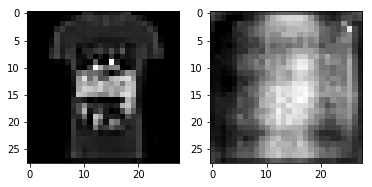

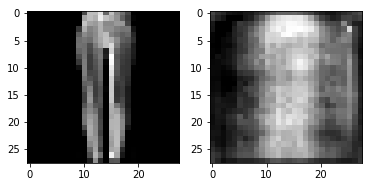

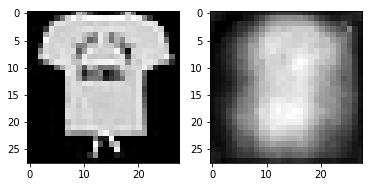

In [38]:
#显示3张图像及其重建图像
for i in range(3):
    show(b_x_np[i],x_reconst_np[i])